# acoustical analysis: guerledan 2024/06

In [1]:
import os 

import numpy as np
import pandas as pd
import xarray as xr

import scipy.signal as signal
#from scipy.stats import f as fisher_dist
#from scipy.interpolate import interp1d
#from sympy import nsimplify

import matplotlib.pyplot as plt
#import hvplot as hv
import hvplot.xarray
import hvplot.pandas

import librosa as lb
import soundfile as sf
from IPython.display import Audio

In [2]:
#root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_seabot"
root_dir = "/Users/aponte/Current_Projects/ensta/guerledan/"

wav_ref = os.path.join("/Users/aponte/Code/geoloc/data/sig_COGNAC_essais_juin_2024.wav")
y_ref, sr_ref = lb.load(wav_ref, sr=None)

seabot_dir = os.path.join(root_dir, "202406/data_seabot/test_acoustic_2024_06_26/seabot2")
wav = os.path.join(seabot_dir, "listen-13-56-01.wav")
y, sr = lb.load(wav, sr=None)

In [3]:
print(f"sampling rate (reference) = {sr_ref} Hz")
T = y.size/sr
print(f"time series length (reference) = {T} s")

sampling rate (reference) = 78125 Hz
time series length (reference) = 3799.871875 s


In [4]:
print(f"sampling rate = {sr} Hz")
T_ref = y_ref.size/sr
print(f"time series length = {T_ref} s")

sampling rate = 48000 Hz
time series length = 9.186604166666667 s


In [5]:
# a bit slow
#Audio(data=y, rate=sr)

[Text(0.5, 1.0, 'Mel spectrogram')]

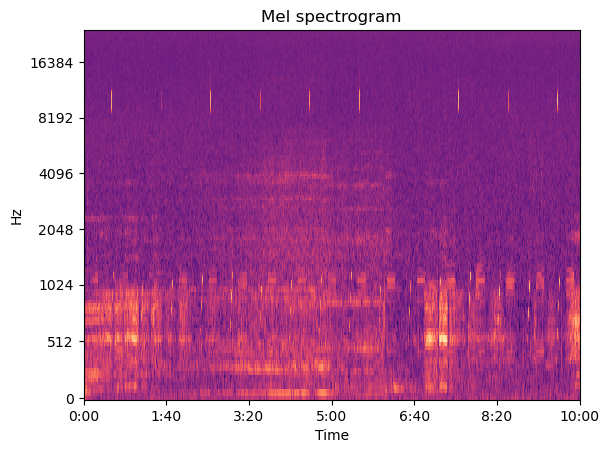

In [6]:
Tb = 60*10
i = 20*60*sr

ys = y[i:i+Tb*sr]

fig, ax = plt.subplots()
melspec = lb.power_to_db(lb.feature.melspectrogram(y=ys, sr=sr), ref=np.max)
lb.display.specshow(melspec, y_axis='mel', x_axis='time', ax=ax, sr=sr)
ax.set(title='Mel spectrogram')
#ax.set_xlim()

[Text(0.5, 1.0, 'Mel spectrogram')]

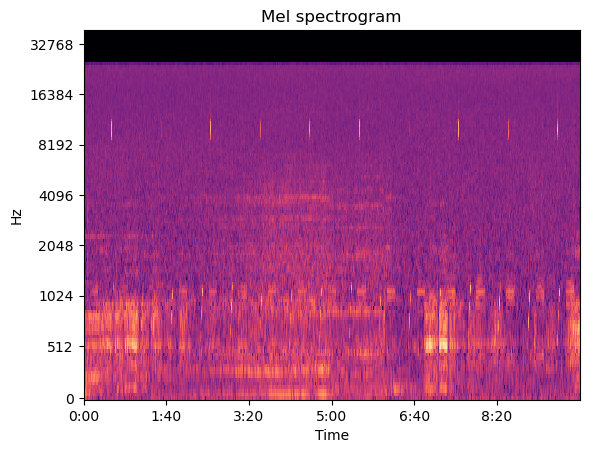

In [7]:
# resampled signal
ys_rs = signal.resample(ys, int(ys.size*sr_ref/sr))

fig, ax = plt.subplots()
melspec = lb.power_to_db(lb.feature.melspectrogram(y=ys_rs, sr=sr_ref), ref=np.max)
lb.display.specshow(melspec, y_axis='mel', x_axis='time', ax=ax, sr=sr_ref)
ax.set(title='Mel spectrogram')

### band-pass filtering

In [8]:
kHz = 1e3

def build_fir(f, bandwidth, T, fs):
    numtaps = int(T * fs)
    pass_zero = False
    cutoff = [f - bandwidth/2, f + bandwidth/2]
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=fs, scale=True
    )
    return h

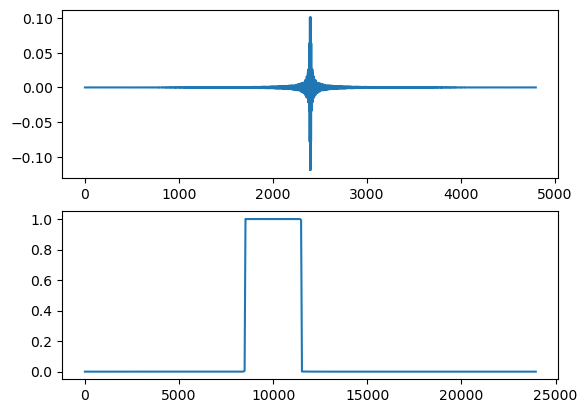

In [9]:
T = .1 # filter kernel width

h = build_fir(10*kHz, 3*kHz, T, sr)
w, hh = signal.freqz(h, worN=512, fs=sr)

fig, axes = plt.subplots(2,1)
axes[0].plot(h)
axes[1].plot(w, np.abs(hh))

In [10]:
ysf = signal.fftconvolve(ys, h, mode="same")
ysf_rs = signal.fftconvolve(ys_rs, h, mode="same")

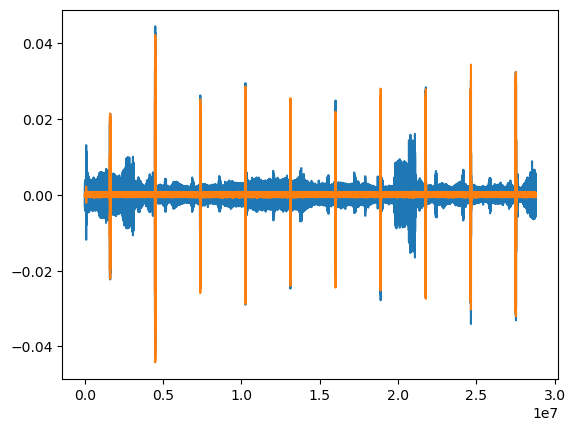

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(ys, label="raw")
ax.plot(ysf, label="bandpass filtered")

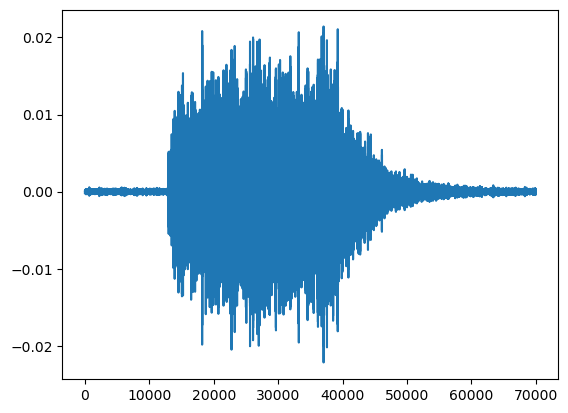

In [12]:
plt.plot(ysf[int(1.58e6):int(1.65e6)])

### detection

In [65]:
def convolve(y, y_ref):
    conv = signal.fftconvolve(signal.hilbert(y), y_ref[::-1], mode="same")
    return conv

In [15]:
c = convolve(ysf_rs, y_ref)

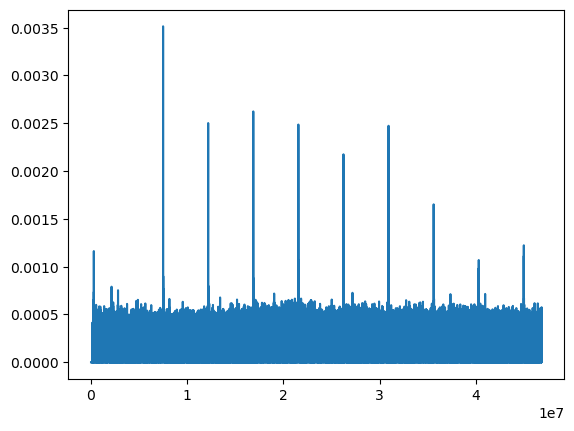

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(c))

In [17]:
#def plot_pd(y):
#    return pd.Series(y).hvplot()
#plot_pd(np.abs(c[6_000_000:8_000_000:5]))

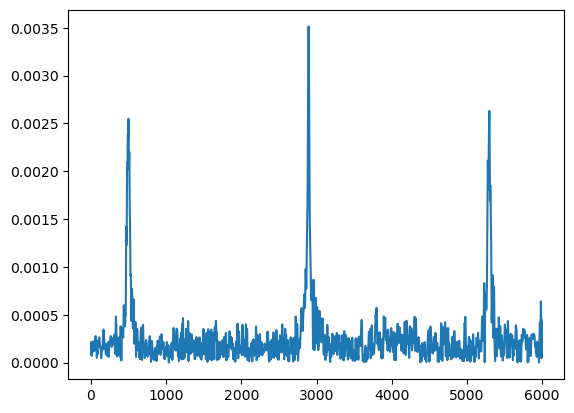

In [18]:
plt.plot(np.abs(c[7_490_000:7_496_000:1]))

In [19]:
2000/sr_ref

0.0256

In [20]:
2000/sr_ref * 1500

38.4

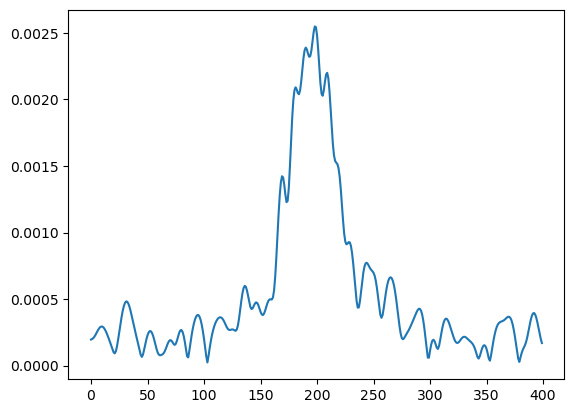

In [21]:
plt.plot(np.abs(c[7_490_300:7_490_700:1]))

In [25]:
100/sr_ref, 200/sr_ref

(0.00128, 0.00256)

In [22]:
100/sr_ref * 1500

1.9200000000000002

### extract local maxima

In [23]:
from scipy.signal import find_peaks_cwt, find_peaks

In [35]:
(1e-3*sr_ref, 5e-3*sr_ref)

(78.125, 156.25)

In [62]:
def detect_peaks(c, sr, **kwargs):
    dkwargs = dict(
        width=(2e-4*sr, 4e-3*sr), 
        distance=50*sr,
    )
    peaks, props = find_peaks(np.abs(c), **dkwargs)
    return pd.DataFrame(props, index=peaks)

In [63]:
df = detect_peaks(c, sr_ref)

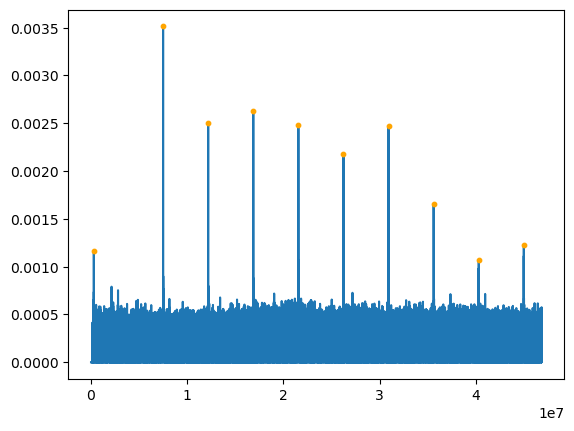

In [64]:
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(c))
ax.scatter(df.index, np.abs(c)[df.index], c="orange", s=10, zorder=10)

In [153]:
# process full time series with rolling operation

def process_one_block(y, sr, y_ref, sr_ref, i0=0):
    # wraps around channels
    if len(y.shape)>1 and y.shape[1]>1:
        return [process_one_block(y[:,i], sr, y_ref, sr_ref, i0=i0) for i in range(y.shape[1])]
    # resampled signal
    y_rs = signal.resample(y, int(y.size*sr_ref/sr))
    # band-pass filter
    yf_rs = signal.fftconvolve(y_rs, h, mode="same")
    # c
    c = convolve(yf_rs, y_ref)
    #
    df = detect_peaks(c, sr_ref)
    # offset index if need be
    df.index += i0
    return df, c

In [135]:
df, c = process_one_block(ys, sr, y_ref, sr_ref)

In [139]:
df.index+10

Index([  291899,  7492905, 12180445, 16867963, 21555481, 26243011, 30930533,
       35618071, 40308051, 44993328],
      dtype='int64')

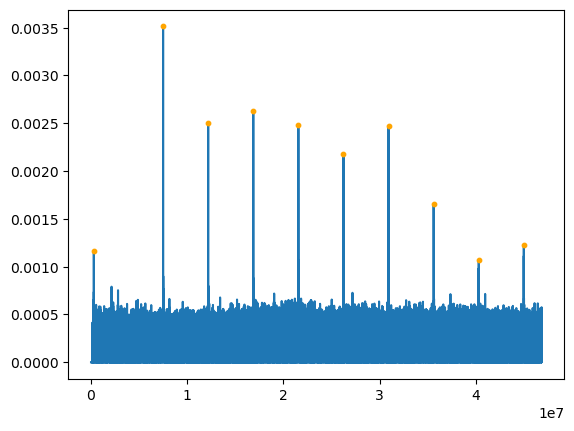

In [136]:
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(c))
ax.scatter(df.index, np.abs(c)[df.index], c="orange", s=10, zorder=10)

In [143]:
#np.vstack?

In [150]:
#plt.plot(y_ref)

In [ ]:
sr

In [157]:
10*48_000

480000

In [166]:
import soundfile as sf
from tqdm import tqdm

def read_wave(wav, block_size=2*60*48_000, overlap=10*48_000, block_i=None):
    print(wav)
    D, I = [], []
    with sf.SoundFile(wav) as f:
        frames = len(f)
        sr = f.samplerate
        if block_i is not None:
            # continued processing
            block, i = block_i
            # skips samples if continued from previous file
            delta = block_size - block.shape[0]
            block = np.vstack((block, f.read(delta)))
            # process block
            df, _ = process_one_block(block, sr, y_ref, sr_ref, i0=i)
            D.append(df)
            i+=block_size-overlap
        else:
            i=0
        for block in tqdm(f.blocks(blocksize=block_size, overlap=overlap)):
            if block.shape[0]==block_size:
                # process block
                df, _ = process_one_block(block, sr, y_ref, sr_ref, i0=i)
                D.append(df)
                #D.append(block.shape)                
                I.append(i)
            i+=block_size-overlap
    return block, D, I

def read_waves(waves, **kwargs):
    block_i = None
    DD, II = [], []
    for w in waves:
        block, D, I = read_wave(w, block_i=block_i, **kwargs)
        block_i = (block, I[-1])
        DD.append(D)
        II.append(I)
    df = pd.DataFrame(
        dict(i=[i for I in II for i in I]),
    )
    return DD, df

In [162]:
#block, D, I = read_wave(wav)

waves = [
    os.path.join(seabot_dir, "wav1.wav"),
    os.path.join(seabot_dir, "wav2.wav"),
]

DD, df = read_waves(waves)

/Users/aponte/Current_Projects/ensta/guerledan/202406/data_seabot/test_acoustic_2024_06_26/seabot2/wav1.wav


2it [04:23, 131.57s/it]


/Users/aponte/Current_Projects/ensta/guerledan/202406/data_seabot/test_acoustic_2024_06_26/seabot2/wav2.wav


4it [04:46, 71.59s/it]


Better strategy:

- find start, end times
- split into overlapping time chunks
- distribute calculation over chunks (or iterate), requires to be able to go search for acoustic time series based on start/end times

In [92]:
class wave(object):
    def __init__(self, wave_file, parser):
        with sf.SoundFile(wave_file) as f:
            self.frames = len(f)
            self.sample_rate = f.samplerate
            self.channels = f.channels
        self.start = parser(wave_file)
        self.end = self.start + pd.to_timedelta(self.frames/self.sample_rate, unit="s")
        self.file = wave_file
    def __repr__(self):
        _str = "wave object"
        _str += f" / start = {self.start}"
        _str += f" / end = {self.end}"
        _str += f" / sample_rate = {self.sample_rate} Hz"
        return _str
    
class waves(object):

    def __init__(self, wave_files, parser):
        #self.files = wave_files
        #info = [parser()]
        # start, end, sampling rate
        # sort data
        self.parser = parser
        self.df = self._browse(wave_files)
        # recompute start time based on sample numbers
        self._compute_start_indexes()

    def _browse(self, files):
        D = []
        for wave_file in files:
            with sf.SoundFile(wave_file) as f:
                d = dict(
                    frames = len(f),
                    sample_rate = f.samplerate,
                    channels = f.channels,
                    start = parser(wave_file)
                )
                d["end"] = d["start"] + pd.to_timedelta(d["frames"]/d["sample_rate"], unit="s")
                d["file"] = wave_file
                D.append(d)
        df = pd.DataFrame(D).sort_values(by="start")
        return df

    def _compute_start_indexes(self):
        df = self.df
        df["start_indexes"] = (df["frames"] * df["sample_rate"]).cumsum() # needs to be shifted
        df["start_updated"] = df.iloc[0]["start"] + pd.to_timedelta(df["start_indexes"]/df["sample_rate"], unit="s")

    def chunk():
        pass
            
    def time2index():
        pass

In [93]:
parser = lambda file: pd.to_datetime('2000-01-01 00:00') #+ pd.to_timedelta(int(file.replace("wav", "")[:-1]), unit="h")
#w = wave(wav, parser)

In [94]:
wave_files = [
    os.path.join(seabot_dir, "wav1.wav"),
    os.path.join(seabot_dir, "wav2.wav"),
]

ws = waves(wave_files, parser)

In [96]:
ws.df

,frames,sample_rate,channels,start,end,file,start_indexes,start_updated
0,23552735,44100,2,2000-01-01,2000-01-01 00:08:54.075623583,/Users/aponte/Current_Projects/ensta/guerledan...,1038675613500,2000-09-29 14:25:35
1,50835580,44100,2,2000-01-01,2000-01-01 00:19:12.734240363,/Users/aponte/Current_Projects/ensta/guerledan...,3280524691500,2002-05-10 23:25:15


In [77]:
self = ws

0    1038675613500
1    3280524691500
dtype: int64

In [7]:
f = sf.SoundFile(wav)
f

SoundFile('/Users/aponte/Current_Projects/ensta/guerledan/202406/data_seabot/test_acoustic_2024_06_26/seabot2/listen-13-56-01.wav', mode='r', samplerate=48000, channels=2, format='WAV', subtype='PCM_32', endian='FILE')

In [8]:
f.channels

2

---
## dev

In [ ]:
# cannot get 

def build_iir(f, bandwidth, T, fs, order=17):
    #numtaps = int(T * fs)
    cutoff = [(f - bandwidth/2), (f + bandwidth/2)]
    #
    b, a = signal.iirfilter(
        order, cutoff, fs=fs,
    )
    return b, a

b, a = build_iir(10*kHz, 1*kHz, T, sr)
w, hh = signal.freqs(b, a)

fig, axes = plt.subplots(2,1)
axes[0].plot(w/np.pi *sr, np.abs(hh))
axes[1].plot(w/np.pi *sr, np.angle(hh))

In [71]:
lb.load?

Signature:
lb.load(
    path: 'Union[str, int, os.PathLike[Any], sf.SoundFile, audioread.AudioFile, BinaryIO]',
    *,
    sr: 'Optional[float]' = 22050,
    mono: 'bool' = True,
    offset: 'float' = 0.0,
    duration: 'Optional[float]' = None,
    dtype: 'DTypeLike' = <class 'numpy.float32'>,
    res_type: 'str' = 'soxr_hq',
) -> 'Tuple[np.ndarray, Union[int, float]]'
Docstring:
Load an audio file as a floating point time series.

Audio will be automatically resampled to the given rate
(default ``sr=22050``).

To preserve the native sampling rate of the file, use ``sr=None``.

Parameters
----------
path : string, int, pathlib.Path, soundfile.SoundFile, audioread object, or file-like object
    path to the input file.

    Any codec supported by `soundfile` or `audioread` will work.

    Any string file paths, or any object implementing Python's
    file interface (e.g. `pathlib.Path`) are supported as `path`.

    If the codec is supported by `soundfile`, then `path` can also be
    